# LEITURA DE DADOS E IMPORTAÇÃO DE BIBLIOTECAS

In [1]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_BDS = '../bds/'

# DEFININDO UMA LISTA COM OS NOMES DAS AÇÕES QUE ESTAMOS UTILIZANDO
data_names = ['TSLA', 'BYDDY', 'LCID', 'LI']

In [2]:
# DICIONARIO DE SÉRIES TEMPORAIS
times_series = {}
for name in data_names:
    times_series[name] = pd.read_csv(DATA_PATH_BDS + name + '.csv',sep=',')

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

# INFORMAÇÕES SOBRE AS SÉRIES TEMPORAIS

As séries temporais que serão estudadas nesse arquivos são sobre o valor de fechamento sobre os preços de ações de algumas empresas no setor de predução de carros elétricos, realizaremos alguns estudos e testes de modelos.

Um dos objetivos é identificar modelos para a modelagem de séries temporais financeiras, entender o comportamento delas e fazer previões baseadas nos modelos que criamos.



$\textbf{1. Tesla, Inc. (TSLA)} \\$
A Tesla é uma das líderes globais na produção de veículos elétricos e soluções de armazenamento de energia. Fundada por Elon Musk, a empresa é conhecida por seus carros elétricos de alto desempenho, como o Model S, Model 3, Model X e Model Y. Além de veículos elétricos, a Tesla também produz baterias e sistemas de energia solar. \\

$\textbf{2. BYD Company Limited (BYDDY)} \\$
A BYD é uma das maiores fabricantes de veículos elétricos e baterias do mundo. Com sede na China, a empresa produz uma ampla gama de veículos elétricos, incluindo ônibus e carros de passageiros, além de baterias e tecnologias de energia renovável. A BYD tem um forte foco em soluções sustentáveis e é uma das líderes no mercado de veículos elétricos na China. \\

$\textbf{3. Lucid Motors Inc. (LCID)} \\$
Lucid Motors é uma fabricante de veículos elétricos de luxo com sede na Califórnia. A empresa é conhecida por seu sedã elétrico de alto desempenho, o Lucid Air, que compete com modelos premium como o Tesla Model S. Lucid se destaca por seu foco em tecnologia avançada e design sofisticado.

$\textbf{4. Li Auto Inc. (LI)} \\$
Li Auto é uma fabricante chinesa de veículos elétricos e híbridos plug-in. A empresa é conhecida por seus SUVs híbridos, como o Li ONE. Li Auto se concentra em fornecer veículos elétricos com tecnologias avançadas e uma extensa rede de recarga e suporte. \\

$\textbf{5. NIO Inc. (NIO)} \\$
A NIO é uma fabricante de veículos elétricos premium com sede na China. A empresa é conhecida por seus SUVs elétricos e sedans, como o ES8, ES6 e o EC6. A NIO também se destaca por seu modelo de substituição de bateria, oferecendo um serviço onde os clientes podem trocar as baterias de seus veículos em estações de troca rápida. \\



# PRÉ-PROCESSAMENTO

Na modelagem durante todo o processo nesse arquivo, estaremos utilizando apenas os dados de Data (Date) e de valor de fechamento das ações (Close), então na etapa abaixo estamos deixando, em nossos conjuntos de dados apenas as colunas de **Data** e **Close**.

In [4]:
for name in data_names:
    times_series[name] = times_series[name][['Date','Close']]

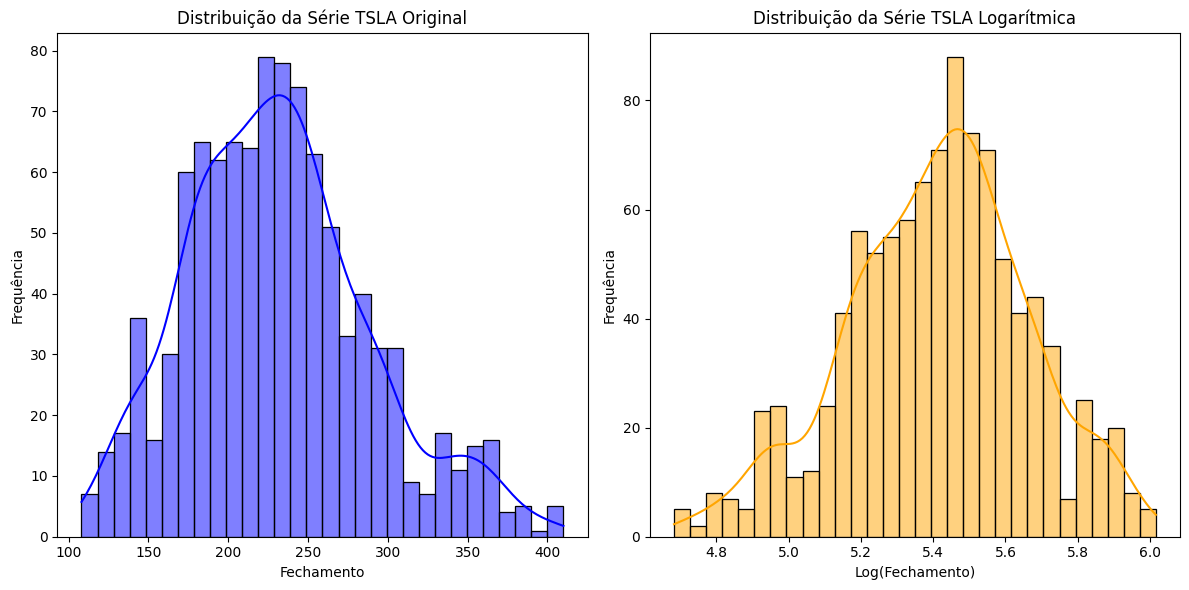

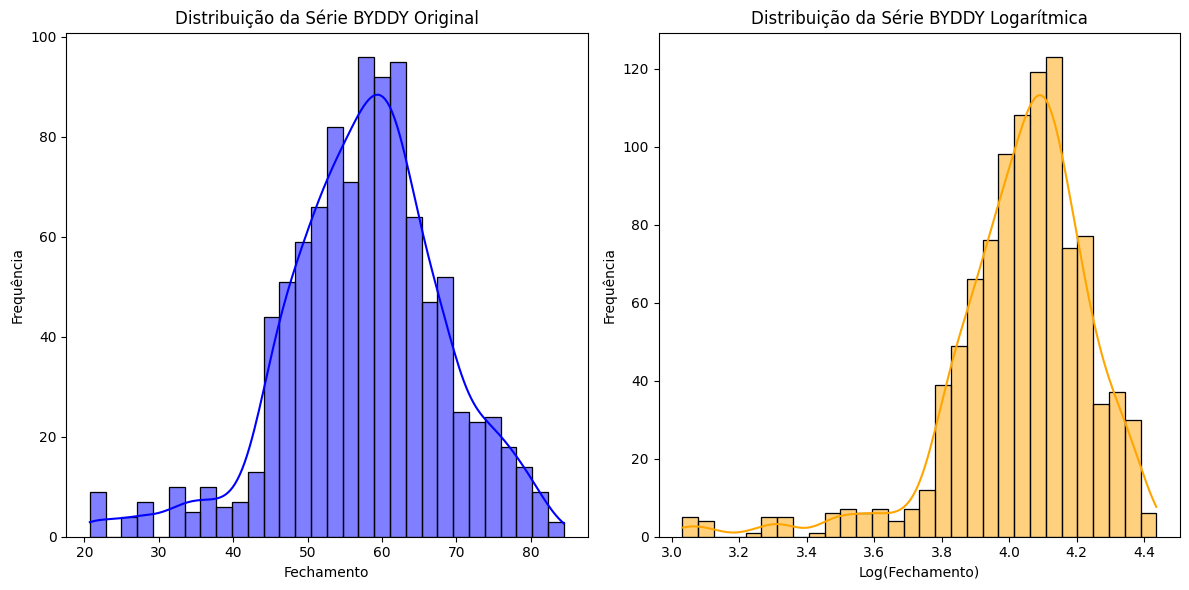

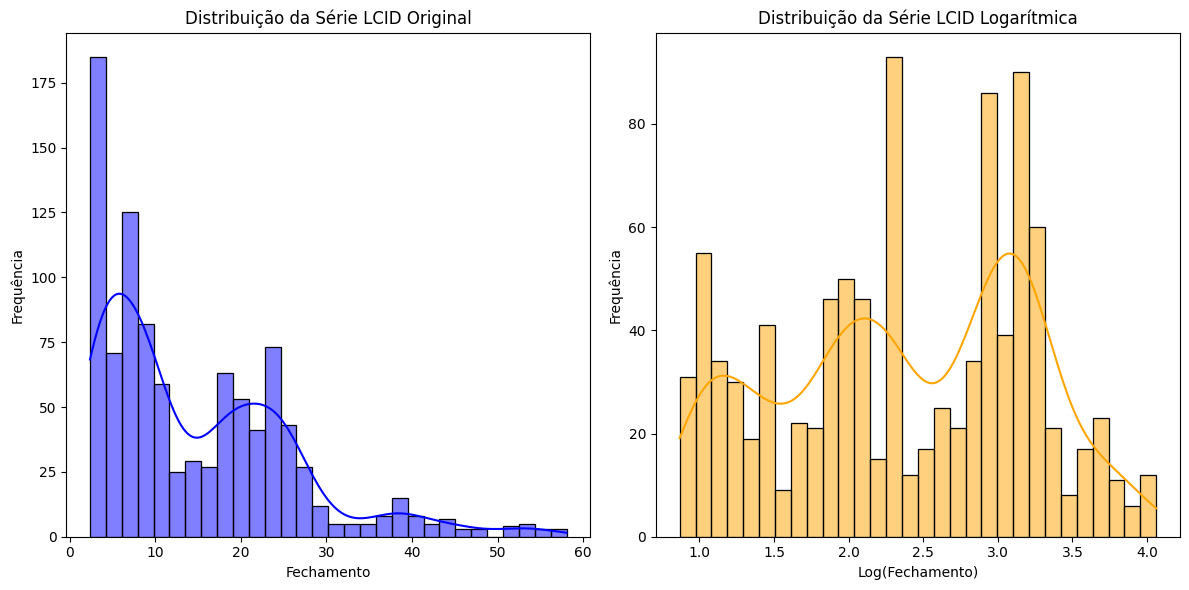

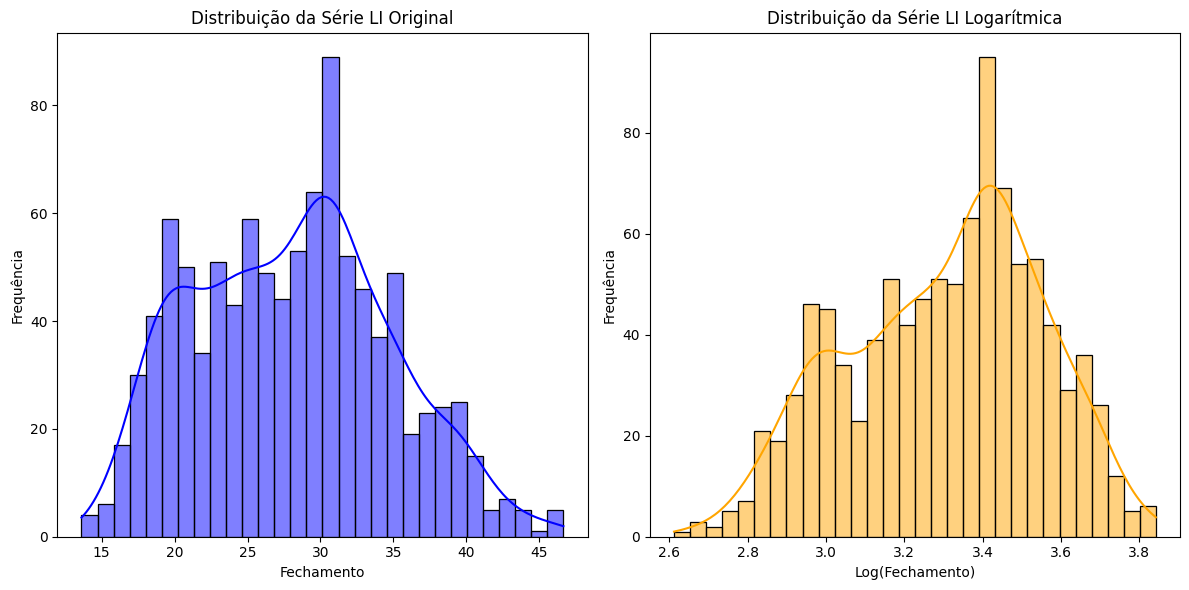

In [5]:
for name in data_names:
    plt.figure(figsize=(12, 6))

    # Verificar se há zeros ou valores negativos
    close_values = times_series[name]['Close']
    
    if (close_values <= 0).any():
        print(f"A série {name} contém zeros ou valores negativos.")
    
    # Plotar a distribuição da série original
    plt.subplot(1, 2, 1)
    sns.histplot(close_values, bins=30, kde=True, color='blue')
    plt.title(f'Distribuição da Série {name} Original')
    plt.xlabel('Fechamento')
    plt.ylabel('Frequência')

    # Aplicar a transformação logarítmica, substituindo zeros e negativos por NaN
    close_log = np.log(close_values.replace(0, np.nan).replace(-1, np.nan))

    # Plotar a distribuição da série transformada logaritmicamente
    plt.subplot(1, 2, 2)
    sns.histplot(close_log.dropna(), bins=30, kde=True, color='orange')  # Dropar NaNs para a plotagem
    plt.title(f'Distribuição da Série {name} Logarítmica')
    plt.xlabel('Log(Fechamento)')
    plt.ylabel('Frequência')

    plt.tight_layout()
    plt.show()

In [6]:
from scipy.stats import shapiro

Com o teste de shapiro é um teste de normalidade, onde vamos varificar se o nosso conjunto de dados segue a distribuição normal. Uma distribuição log-normal diz-se normal então, significa que a transformação normal ou deixa a série temporal seguindo a distribuição normal ou que não houve mudança ao ser aplicada, por exemplo se os dados originais já seguem a distribuição normal.

In [7]:
# Criar uma lista para armazenar os resultados
resultados = []
for name in data_names:
    close_values = times_series[name]['Close']
    
    # Verificar se há zeros ou valores negativos
    if (close_values <= 0).any():
        print(f"A série {name} contém zeros ou valores negativos.")

    # Teste de normalidade para a série original
    stat, p_value = shapiro(close_values.dropna())
    normal_original = p_value > 0.05

    # Aplicar a transformação logarítmica, substituindo zeros e negativos por NaN
    close_log = np.log(close_values.replace(0, np.nan).replace(-1, np.nan))

    # Teste de normalidade para a série logarítmica
    stat_log, p_value_log = shapiro(close_log.dropna())
    normal_log = p_value_log > 0.05

    # Armazenar os resultados
    resultados.append({
        'Série': name,
        'Normalidade Original': 'Sim' if normal_original else 'Não',
        'Normalidade Logarítmica': 'Sim' if normal_log else 'Não'
    })
# Criar um DataFrame com os resultados
resultado_df = pd.DataFrame(resultados)
# Exibir a tabela de resultados
print(resultado_df)

   Série Normalidade Original Normalidade Logarítmica
0   TSLA                  Não                     Não
1  BYDDY                  Não                     Não
2   LCID                  Não                     Não
3     LI                  Não                     Não


Nesta etapa, vamos se dedicar ao estudo de Lags relevantes, que estão associado ao teste de associação. Queremos fazer estudo em períodos diferentes do tempo para achar uma associação entre esse período do tempo na influencia nos demais.

Usaremos a autocorrelação parcial para fazer o estudo de Lags significativos nas nossas séries temporais. A Autocorrelação Parcial (PACF) mede a correlação entre uma variável(ou período de tempo neste caso) e suas defasagens, removendo o efeito das defasagens intermediárias.



$$
R_k = \frac{1}{N} \sum_{t=1}^{N-k} (X_t - \mu)(X_{t+k} - \mu)
$$

Onde:
\begin{align*}
R_k & : \text{ autocorrelação no lag } k \\
N & : \text{ número total de observações na série} \\
X_t & : \text{ valor da série no tempo } t \\
X_{t+k} & : \text{ valor da série no tempo } t+k \\
\mu & : \text{ média da série}
\end{align*}

Para obter os lags significantes aplicamos um teste de hipótese, onde :

$$
(H_0): \text{O lag é significante} \\

(H_a): \text{O lag não é significante}
$$

Vamos aceitar ($H_0$) quando nossa autocorrelação parcial estiver fora do nosso intervalo de confiança então vamos ter que o nosso lag no instante i é significante, caso contrário, aceitamos ($H_a$).

In [8]:
def get_lags_significants(target, n_lags = 5, alpha = 0.05):
    pac, pac_ci = sm.tsa.pacf(x = target, nlags = n_lags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    sm.graphics.tsa.plot_pacf(target, lags=n_lags)
    significantLags = []
    for i in range(1, len(pac)):
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags

def get_all_lags_significants(data, var_names, qtd_lags):
    significants_lags = {}
    # Itera sobre as variáveis e suas respectivas quantidades de lags
    for name, lags in zip(var_names, qtd_lags):
        significants_lags[name] = get_lags_significants(data[name]['Close'], lags)
        
    
    return significants_lags

In [9]:
data_names

['TSLA', 'BYDDY', 'LCID', 'LI']

significantLags: [1, 5, 8, 10]
significantLags: [1]
significantLags: [1, 5]
significantLags: [1]


{'TSLA': [1, 5, 8, 10], 'BYDDY': [1], 'LCID': [1, 5], 'LI': [1]}

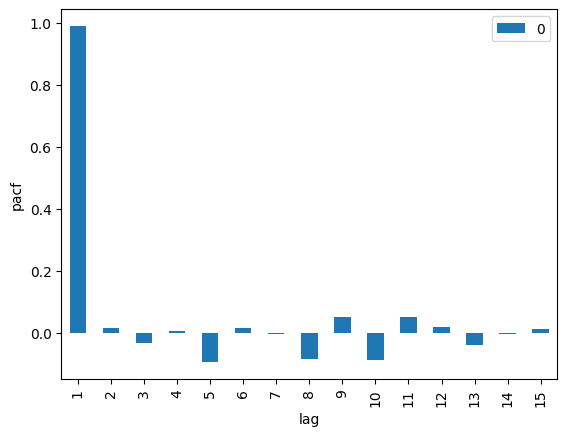

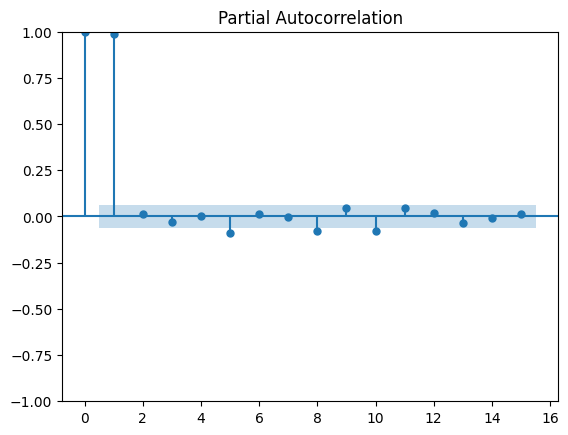

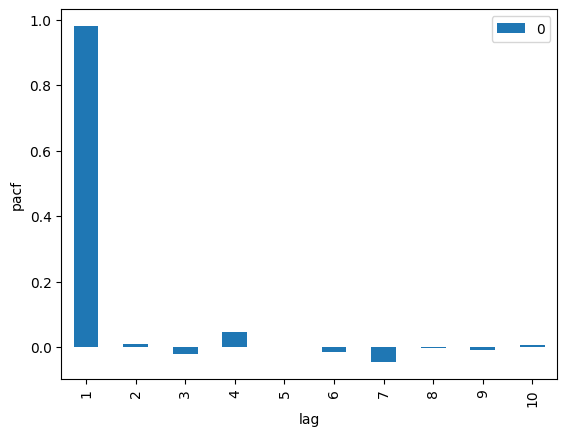

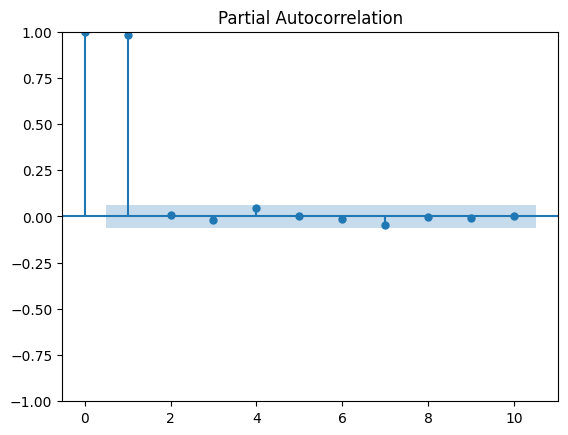

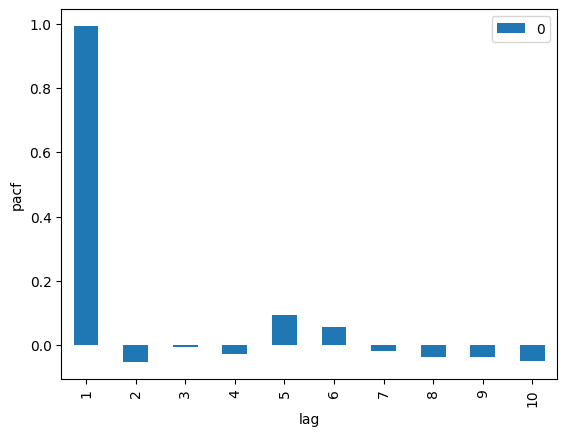

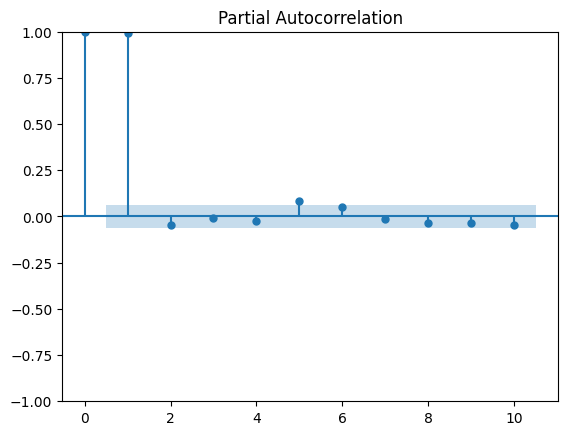

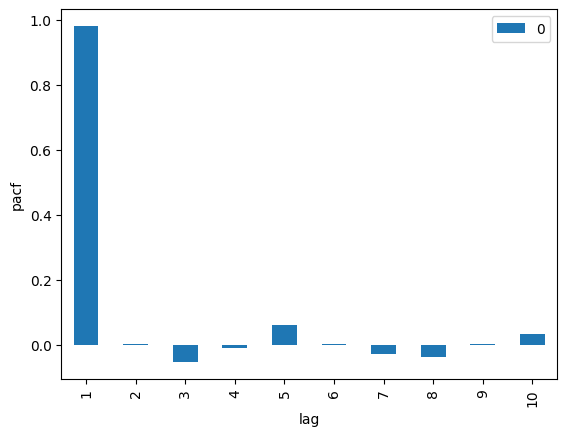

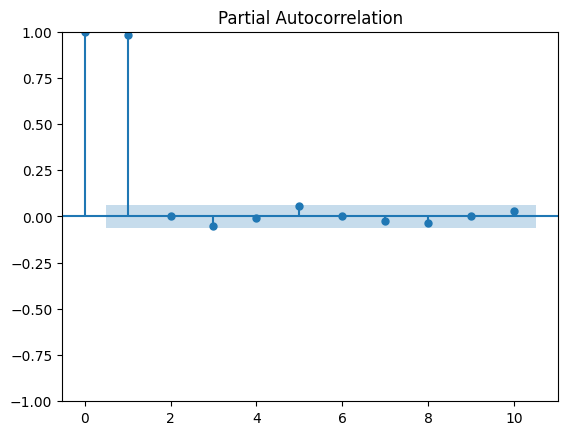

In [10]:
qtd_lags = [15,10,10,10]
all_significants_lags = get_all_lags_significants(times_series, data_names, qtd_lags)
all_significants_lags

Nesta etapa, vamos preparar os nossos dados para a etapa de modelagem, dividindo o nosso conjunto de treino e teste. Estaremos usando 80% das nossas observações para o treino enquanto que 20% será reservado para o teste.

In [11]:
data_train = {}
data_test= {}
for name in data_names:
    data_train[name], data_test[name] = train_test_split(times_series[name], test_size=0.2, shuffle=False)

Também vamos nos dedicar ao estudo com os lags, então precisamos tem os conjuntos de dados com os Lags e fazer a divisão deles entre treino e teste.

Abaixo, estamos colocando no nosso datraframe os nossos lags relevantes que achamos via a autocorrelação parcial e depois dividindo a série temporal com os lags em um conjunto de treino (80%) e em teste (20%).


In [12]:
def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df
"""TM_tesla = appendLagVariables(yNm='Close', 
                         significantLags = e1_significantLags, 
                         df = TM_tesla, 
                         dropna=True)"""

"TM_tesla = appendLagVariables(yNm='Close', \n                         significantLags = e1_significantLags, \n                         df = TM_tesla, \n                         dropna=True)"

In [13]:
times_series_with_lags = {}
for name in data_names:
    times_series_with_lags[name] = appendLagVariables(
        yNm='Close',
        significantLags=all_significants_lags[name],
        df = times_series[name]
    )

,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
10,2020-09-16,147.253326,149.919998,122.093330,135.666672,158.350006
11,2020-09-17,141.143326,147.253326,123.779999,139.440002,149.123337


,Date,Close,(Close-1)
1,2020-09-02,22.299999,22.350000
2,2020-09-03,21.080000,22.299999


,Date,Close,(Close-1),(Close-5)
5,2020-09-25,9.81,9.77,9.89
6,2020-09-28,9.83,9.81,9.86


,Date,Close,(Close-1)
1,2020-09-02,17.870001,18.290001
2,2020-09-03,16.910000,17.870001


In [14]:
data_train_with_lags = {}
data_test_with_lags = {}
for name in data_names:
    data_train_with_lags[name], data_test_with_lags[name] = train_test_split(times_series_with_lags[name], test_size=0.2, shuffle=False)

# ANÁLISE ESTATÍSTICA DAS SÉRIES TEMPORAIS

## ESTUDOS DESCRITIVOS

Nesta seção, já temos os nossos dados preparados e pronto para as análises estatísticas e modelagem da série temporal, nesta seção vamos realizar uma abordagem estatística para obter o máximo de insights possíveis de cada série temporal e a conjunta.

In [15]:
print("------------> CONJUNTO DE TREINO SEM LAGS")
for name in data_names:
    print("+"+ "-"*35 + "+")
    print(f'Nº de meses em {name}: {len(times_series[name])}')
    print(f'Nº de meses no treino de {name}: {len(data_train[name])}')
    print(f'Nº de meses no teste de {name}: {len(data_train[name])}')

print("------------> CONJUNTO DE TREINO COM LAGS")
for name in data_names:
    print("+"+ "-"*35 + "+")
    print(f'Nº de meses em {name}: {len(times_series_with_lags[name])}')
    print(f'Nº de meses no treino de {name}: {len(data_train_with_lags[name])}')
    print(f'Nº de meses no teste de {name}: {len(data_train_with_lags[name])}')

------------> CONJUNTO DE TREINO SEM LAGS
+-----------------------------------+
Nº de meses em TSLA: 1006
Nº de meses no treino de TSLA: 804
Nº de meses no teste de TSLA: 804
+-----------------------------------+
Nº de meses em BYDDY: 1006
Nº de meses no treino de BYDDY: 804
Nº de meses no teste de BYDDY: 804
+-----------------------------------+
Nº de meses em LCID: 994
Nº de meses no treino de LCID: 795
Nº de meses no teste de LCID: 795
+-----------------------------------+
Nº de meses em LI: 1006
Nº de meses no treino de LI: 804
Nº de meses no teste de LI: 804
------------> CONJUNTO DE TREINO COM LAGS
+-----------------------------------+
Nº de meses em TSLA: 996
Nº de meses no treino de TSLA: 796
Nº de meses no teste de TSLA: 796
+-----------------------------------+
Nº de meses em BYDDY: 1005
Nº de meses no treino de BYDDY: 804
Nº de meses no teste de BYDDY: 804
+-----------------------------------+
Nº de meses em LCID: 989
Nº de meses no treino de LCID: 791
Nº de meses no teste d

Plotaremos nesse momento as séries temporais a quais estamos trabalhando.

In [16]:
print(f"ESTAMOS TRABALHANDO COM AS SÉRIES TEMPORAIS: {data_names}")

ESTAMOS TRABALHANDO COM AS SÉRIES TEMPORAIS: ['TSLA', 'BYDDY', 'LCID', 'LI']


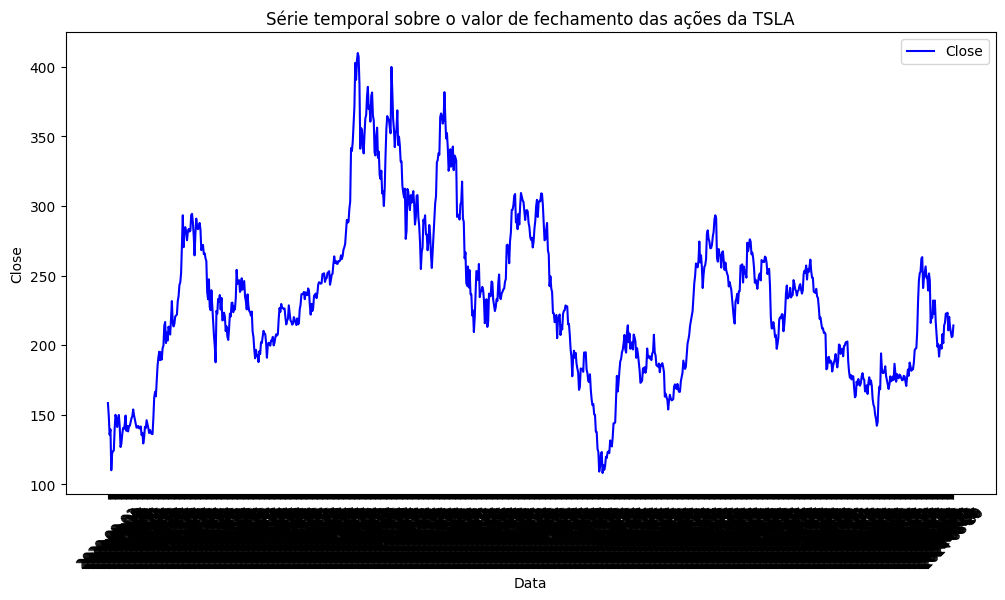

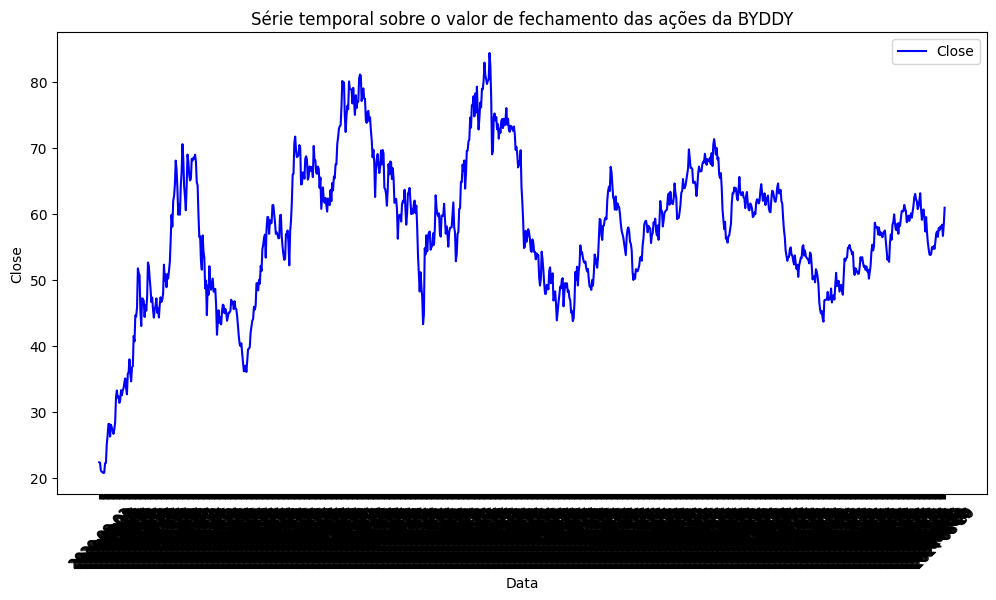

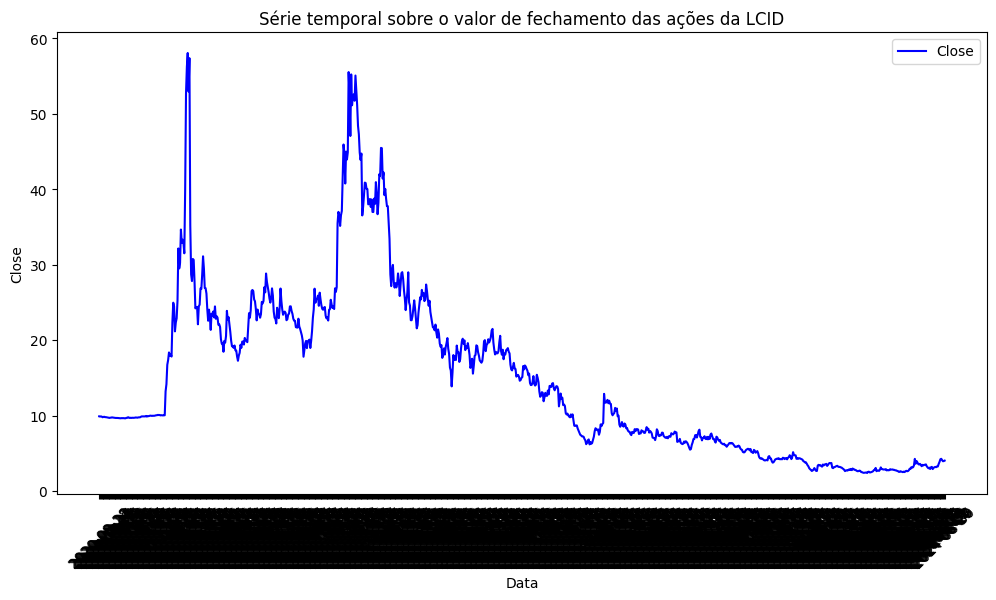

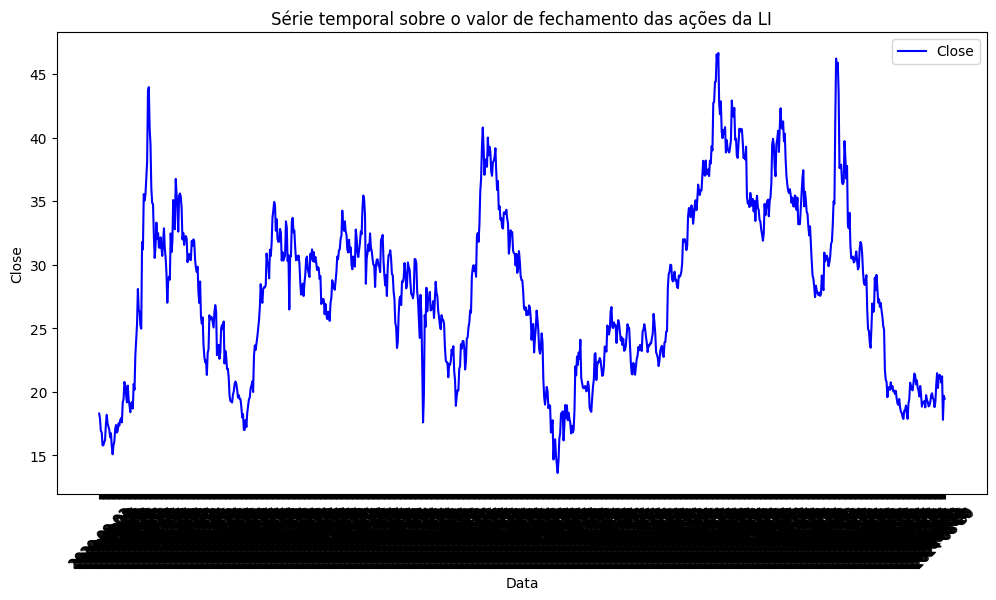

In [17]:
for name in data_names:
    plt.figure(figsize=(12, 6))
    plt.plot(times_series[name]["Date"], times_series[name]["Close"], label='Close', color='blue')
    plt.xlabel('Data')
    plt.ylabel('Close')
    plt.title(f'Série temporal sobre o valor de fechamento das ações da {name}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

Vamos estudar agora, as estatítiscas descritivas no nosso conjunto de treino de teste sem nossos lags das nossas séries temporais.

In [18]:
for name in data_names:
    print(f"SÉRIE TEMPORAL: {name}")
    print(f"--> Estatísticas descritivas básicas do conjunto de treinamento sem lags")
    display(data_train[name].describe())
    print(f"--> Estatísticas descritivas básicas do conjunto de teste sem lags")
    display(data_test[name].describe())

SÉRIE TEMPORAL: TSLA
--> Estatísticas descritivas básicas do conjunto de treinamento sem lags


,Close
count,804.000000
mean,238.181667
std,60.683750
min,108.099998
25%,197.527500
50%,235.925003
75%,275.442490
max,409.970001


--> Estatísticas descritivas básicas do conjunto de teste sem lags


,Close
count,202.000000
mean,203.282079
std,30.201061
min,142.050003
25%,177.542496
50%,197.455002
75%,234.142506
max,263.260010


SÉRIE TEMPORAL: BYDDY
--> Estatísticas descritivas básicas do conjunto de treinamento sem lags


,Close
count,804.000000
mean,58.326144
std,11.578837
min,20.730000
25%,51.207500
50%,59.775000
75%,66.099998
max,84.419998


--> Estatísticas descritivas básicas do conjunto de teste sem lags


,Close
count,202.000000
mean,54.771782
std,4.574762
min,43.680000
25%,51.685001
50%,54.470001
75%,58.187501
max,64.629997


SÉRIE TEMPORAL: LCID
--> Estatísticas descritivas básicas do conjunto de treinamento sem lags


,Close
count,795.000000
mean,17.607984
std,10.866388
min,3.755000
25%,8.295000
50%,16.629999
75%,23.750000
max,58.049999


--> Estatísticas descritivas básicas do conjunto de teste sem lags


,Close
count,199.000000
mean,3.259925
std,0.643448
min,2.380000
25%,2.750000
50%,3.120000
75%,3.625000
max,5.140000


SÉRIE TEMPORAL: LI
--> Estatísticas descritivas básicas do conjunto de treinamento sem lags


,Close
count,804.000000
mean,27.997127
std,6.507902
min,13.620000
25%,23.224999
50%,28.224999
75%,32.260000
max,46.650002


--> Estatísticas descritivas básicas do conjunto de teste sem lags


,Close
count,202.000000
mean,28.098762
std,7.423253
min,17.799999
25%,20.327499
50%,28.345000
75%,34.272501
max,46.209999


Vamos estudar agora, as estatítiscas descritivas no nosso conjunto de treino de teste com nossos lags das nossas séries temporais.

In [19]:
for name in data_names:
    print(f"SÉRIE TEMPORAL: {name}")
    print(f"--> Estatísticas descritivas básicas do conjunto de treinamento com lags")
    display(data_train_with_lags[name].describe())
    print(f"--> Estatísticas descritivas básicas do conjunto de teste com lags")
    display(data_test_with_lags[name].describe())

SÉRIE TEMPORAL: TSLA
--> Estatísticas descritivas básicas do conjunto de treinamento com lags


,Close,(Close-1),(Close-5),(Close-8),(Close-10)
count,796.000000,796.000000,796.000000,796.000000,796.000000
mean,239.426964,239.334263,238.883342,238.540925,238.416520
std,59.859504,59.940957,60.442640,60.814886,60.937944
min,108.099998,108.099998,108.099998,108.099998,108.099998
25%,200.576664,199.760834,198.935833,197.527500,197.290001
50%,236.318329,236.318329,236.318329,236.318329,236.318329
75%,276.017509,276.017509,276.017509,276.017509,276.017509
max,409.970001,409.970001,409.970001,409.970001,409.970001


--> Estatísticas descritivas básicas do conjunto de teste com lags


,Close,(Close-1),(Close-5),(Close-8),(Close-10)
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,203.123100,203.171100,203.343450,203.360900,203.174300
std,30.306751,30.331832,30.392956,30.394686,30.338026
min,142.050003,142.050003,142.050003,142.050003,142.050003
25%,177.524994,177.524994,177.524994,177.524994,177.524994
50%,197.415001,197.415001,197.415001,197.415001,197.415001
75%,234.232506,234.232506,234.232506,234.232506,234.232506
max,263.260010,263.260010,263.260010,263.260010,263.260010


SÉRIE TEMPORAL: BYDDY
--> Estatísticas descritivas básicas do conjunto de treinamento com lags


,Close,(Close-1)
count,804.000000,804.000000
mean,58.375261,58.326144
std,11.509588,11.578837
min,20.730000,20.730000
25%,51.287501,51.207500
50%,59.799999,59.775000
75%,66.099998,66.099998
max,84.419998,84.419998


--> Estatísticas descritivas básicas do conjunto de teste com lags


,Close,(Close-1)
count,201.000000,201.000000
mean,54.736617,54.740995
std,4.558733,4.565158
min,43.680000,43.680000
25%,51.650002,51.650002
50%,54.470001,54.470001
75%,58.150002,58.150002
max,64.629997,64.629997


SÉRIE TEMPORAL: LCID
--> Estatísticas descritivas básicas do conjunto de treinamento com lags


,Close,(Close-1),(Close-5)
count,791.000000,791.000000,791.000000
mean,17.640097,17.647114,17.677183
std,10.886742,10.879868,10.850031
min,3.755000,3.755000,3.950000
25%,8.220000,8.265000,8.400000
50%,16.750000,16.750000,16.750000
75%,23.775001,23.775001,23.775001
max,58.049999,58.049999,58.049999


--> Estatísticas descritivas básicas do conjunto de teste com lags


,Close,(Close-1),(Close-5)
count,198.000000,198.000000,198.000000
mean,3.255076,3.256086,3.253182
std,0.641423,0.642790,0.639575
min,2.380000,2.380000,2.380000
25%,2.750000,2.750000,2.750000
50%,3.110000,3.110000,3.110000
75%,3.617500,3.617500,3.617500
max,5.140000,5.140000,5.140000


SÉRIE TEMPORAL: LI
--> Estatísticas descritivas básicas do conjunto de treinamento com lags


,Close,(Close-1)
count,804.000000,804.000000
mean,28.020348,27.997127
std,6.506531,6.507902
min,13.620000,13.620000
25%,23.230000,23.224999
50%,28.235000,28.224999
75%,32.295001,32.260000
max,46.650002,46.650002


--> Estatísticas descritivas básicas do conjunto de teste com lags


,Close,(Close-1)
count,201.000000,201.000000
mean,28.054677,28.141741
std,7.415231,7.416550
min,17.799999,17.799999
25%,20.309999,20.379999
50%,28.340000,28.350000
75%,34.160000,34.310001
max,46.209999,46.209999


## ESTUDOS DE HOMOGENEIDADE

Estudaremos abaixo sobre homogeneidade, estamos interessados no estudo da homogeneidade sobre a variância das séries temporais.

Mas o que é homogeneidade sobre a variância? Se refere à ideia de que as variâncias das diferentes amostras ou grupos de dados devem ser semelhantes.

O teste padrão de homogeneidade de variâncias, teste de Bartlett, é uma ferramenta eülciente somente se as variávies possuem distribuição aproximadamente normal. Quando a suposição de normalidade é violada, o tamanho real do teste(níve de significância atingido) pode ser muito maior do que o nível de significância fixado. Um procedimento que é relativamente insensível a desvios da normalidade é o Teste de Levene. (ALMEIDA, 2006, 4)

Sejas $X_1,...,X_n$ amostras aleatórias e independentes entre si. Essas amostras aleatórias e independentes entre sí têm distribuição $G_i$, com média $\mu_i$ e variância igual a $\sigma_i^2$. Para o nosso teste de hipótese vamos ter que:

$$
H_0: \sigma_1^2=...=\sigma_n^2
$$
$$
H_a: \sigma_1^2\neq...\neq\sigma_n^2
$$

O teste de Levene consiste em rejeitar $H_0$  a favor de $H_a$ se a estatística que veremos abaixo $W_0$ exceder $F_{k-1,n-k,1-\alpha}$, onde é o quantil de ordem $(1-\alpha)$ da distriubição $F$ com $k-1$ e $n-k$ graus de liberdade.

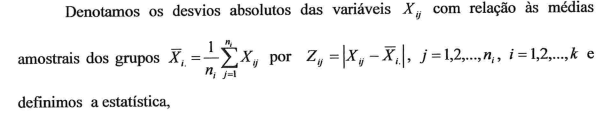

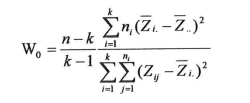

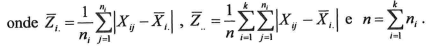

Na aplicação do caso abaixo, rejeitamos nosso $(H_0)$

In [20]:
from scipy.stats import levene
resultados_homogeneidade = []

# Coletar os dados de fechamento de cada série
for name in data_names:
    close_values = times_series[name]['Close'].replace(0, np.nan).dropna()
    resultados_homogeneidade.append(close_values)

# Teste de Levene para homogeneidade de variâncias
stat, p_value = levene(*resultados_homogeneidade)

# Resultados do teste
print(f'Teste de Levene: Estatística={stat:.4f}, p-valor={p_value:.4f}')
if p_value > 0.05:
    print('As variâncias são homogêneas (p > 0.05).')
else:
    print('As variâncias não são homogêneas (p <= 0.05).')

Teste de Levene: Estatística=1006.6810, p-valor=0.0000
As variâncias não são homogêneas (p <= 0.05).


estudar a variabilidade dos resíduos

residuos dos modelos e testar. Qual modelo mais interessante

# ESTUDO DE SÉRIES TEMPORAIS COM A DECOMPOSIÇÃO SVD

Inicialmente, devemos criar nossa matriz da nossa série temporal, na bibliografia chame-se **Lagged Matrix**.

Seja a nossa série temporal $X = \{y_t\}_t^n$, podemos construir a nossa **Lagged Matrix** definida por L como sendo:
$$
L = \begin{pmatrix}
y_t & y_{t-1} & y_{t-2} & y_{t-3} & ... \\
y_{t+1}& y_t  & y_{t-1} & y_{t-2} & ... \\
 \vdots & \ddots & \vdots  & \ddots  & \vdots \\
 \cdots & \cdots & \cdots & \cdots & \cdots  \\
\end{pmatrix}
$$

Onde cada linha contém um conjunto de observações atrasadas da série.

In [21]:
def create_lagged_matrix(series, lags):
    n_rows = len(series) - max(lags)  # Usar o maior lag para calcular o número de linhas
    lagged_matrix = np.zeros((n_rows, len(lags)))
    
    for i, lag in enumerate(lags):
        lagged_matrix[:, i] = series[lag: lag + n_rows]
    
    return lagged_matrix

In [22]:
L = create_lagged_matrix(times_series['TSLA']['Close'], all_significants_lags['TSLA'])

In [23]:
# Aplicando a decomposição SVD
U, S, Vt = np.linalg.svd(L, full_matrices=False)

# Exibindo os componentes
print("Matriz U:")
print(U)
print("\nValores Singulares (S):")
print(S)
print("\nMatriz V transposta (V^T):")
print(Vt)

Matriz U:
[[-0.01854343 -0.00018787  0.06480118  0.01606508]
 [-0.01828447 -0.01470917  0.02948088  0.05427323]
 [-0.01854354 -0.01440183  0.04329438  0.03350736]
 ...
 [-0.02844229  0.01092452 -0.03152019 -0.00081652]
 [-0.02797357  0.0114326   0.00301638  0.00557512]
 [-0.02865845  0.01635485  0.00187105 -0.03461036]]

Valores Singulares (S):
[15054.43572513   652.55527302   326.23724415   240.48430013]

Matriz V transposta (V^T):
[[-0.49890526 -0.50017949 -0.50054318 -0.50037041]
 [ 0.73291845  0.17122427 -0.33498309 -0.56683254]
 [ 0.4563499  -0.75917318 -0.1389172   0.44283503]
 [ 0.07529184 -0.37968252  0.78609469 -0.48189984]]


In [24]:
# Criar a matriz de lags
lagged_matrix = create_lagged_matrix(times_series['TSLA']['Close'].values, all_significants_lags['TSLA'])

# Criar um DataFrame a partir da matriz de lags
lagged_df = pd.DataFrame(lagged_matrix, columns=[f'lag_{i+1}' for i in range(len(all_significants_lags['TSLA']))])

# Adicionar a coluna 'Close' correspondente
# Use o mesmo número de linhas que o lagged_df
lagged_df['Close'] = times_series['TSLA']['Close'][max(all_significants_lags['TSLA']):].values

# Exibir o DataFrame
print(lagged_df.head())

        lag_1       lag_2       lag_3       lag_4       Close
0  149.123337  122.093330  139.873337  147.253326  147.253326
1  135.666672  123.779999  149.919998  141.143326  141.143326
2  139.440002  124.239998  147.253326  147.383331  147.383331
3  110.070000  139.873337  141.143326  149.796661  149.796661
4  122.093330  149.919998  147.383331  141.410004  141.410004


Valores maiores: Indicam componentes que capturam uma quantidade significativa da variação nos dados. Esses componentes podem estar associados a tendências ou padrões dominantes na série temporal.

Valores menores: Indicam componentes que capturam pouca variação, muitas vezes correspondendo a ruído ou flutuações menores.

Veja que o primeiro componente comparado aos outros tem um valor significativamente grande enquanto que os demais valores pequenos, isso pode indicar que a série temporal tem uma estrutura que pode estar associado a um comportamento de "random walk".

In [25]:
S

array([15054.43572513,   652.55527302,   326.23724415,   240.48430013])

In [26]:
variance_explained = (S ** 2) / np.sum(S ** 2)
print("Proporção da variância explicada por cada componente:")
print(variance_explained)

Proporção da variância explicada por cada componente:
[9.97403064e-01 1.87402915e-03 4.68391294e-04 2.54516060e-04]


Valores altos: Capturam padrões significativos e variações.

Valores baixos: Relacionam-se ao ruído e variações não significativas.

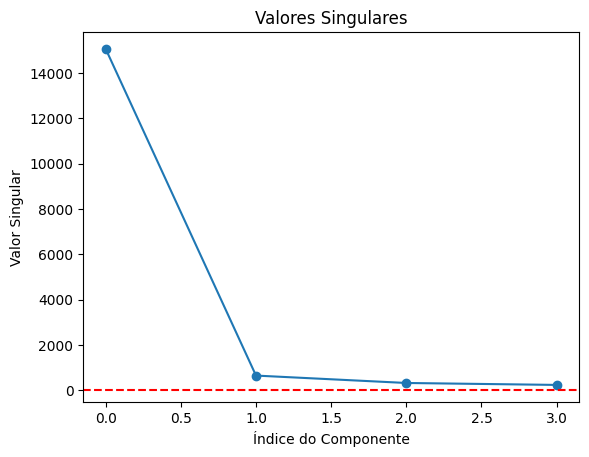

In [27]:
plt.plot(S, marker='o')
plt.title("Valores Singulares")
plt.xlabel("Índice do Componente")
plt.ylabel("Valor Singular")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

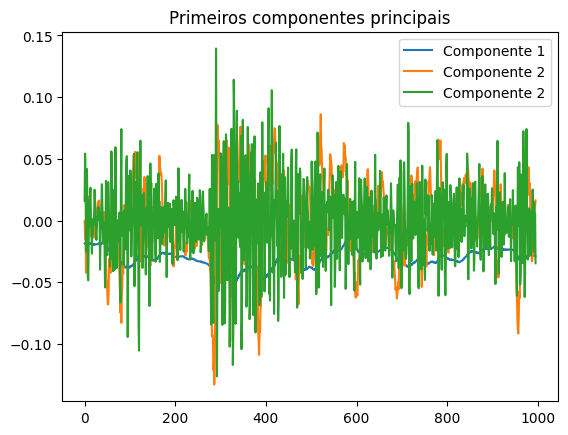

In [28]:
# Plotar os primeiros 2 componentes principais
plt.plot(U[:, 0], label='Componente 1')
plt.plot(U[:, 1], label='Componente 2')
plt.plot(U[:, 3], label='Componente 2')
plt.title("Primeiros componentes principais")
plt.legend()
plt.show()

In [29]:
# Selecionar os primeiros k componentes para reconstrução
k = 1
U_k = U[:, :k]
S_k = np.diag(S[:k])
Vt_k = Vt[:k, :]

# Reconstrução aproximada da matriz original
lagged_matrix_approx = np.dot(U_k, np.dot(S_k, Vt_k))

# Exibir a matriz reconstruída
print("\nMatriz aproximada da série temporal:")
print(lagged_matrix_approx)


Matriz aproximada da série temporal:
[[139.27481465 139.63053159 139.73205808 139.68382837]
 [137.3298626  137.680612   137.7807207  137.7331645 ]
 [139.27566613 139.63138524 139.73291236 139.68468235]
 ...
 [213.6225872  214.16819318 214.32391662 214.24994089]
 [210.10210694 210.63872139 210.79187852 210.7191219 ]
 [215.24608553 215.79583803 215.95274494 215.878207  ]]


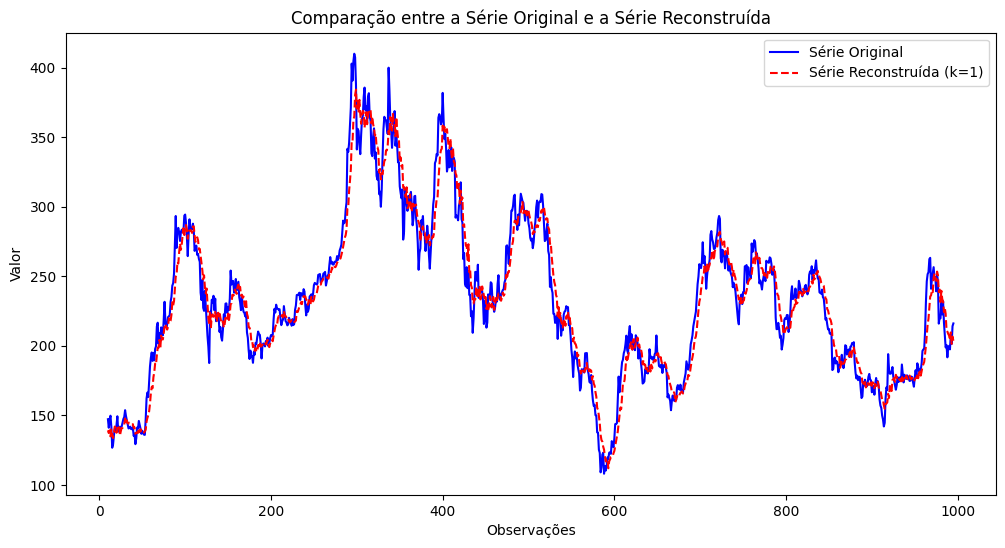

In [30]:
original_series = times_series['TSLA']['Close'].values  # Ajuste conforme necessário

# A série reconstruída da matriz (primeira coluna)
reconstructed_series = lagged_matrix_approx[:, 0]

# Calcular o maior lag
max_lag = max(all_significants_lags['TSLA'])

# Criar uma série com shift
reconstructed_series_shifted = pd.Series(reconstructed_series).shift(max_lag)

# Remover NaNs da série reconstruída e original
# Ajustar para garantir que ambas as séries tenham o mesmo comprimento
original_series_aligned = original_series[max_lag:len(original_series)]  # Limitar o comprimento
reconstructed_series_aligned = reconstructed_series_shifted[max_lag:].dropna()  # Limitar o comprimento e remover NaNs

# Garantir que ambas tenham o mesmo comprimento
min_length = min(len(original_series_aligned), len(reconstructed_series_aligned))

# Criar o DataFrame apenas com os dados que se alinham
aligned_df = pd.DataFrame({
    'Original': original_series_aligned[:min_length],
    'Reconstruída': reconstructed_series_aligned[:min_length]
})

# Plotando
plt.figure(figsize=(12, 6))
plt.plot(aligned_df['Original'], label='Série Original', color='blue')
plt.plot(aligned_df['Reconstruída'], label=f'Série Reconstruída (k={k})', color='red', linestyle='--')
plt.xlabel('Observações')
plt.ylabel('Valor')
plt.title('Comparação entre a Série Original e a Série Reconstruída')
plt.legend()
plt.show()

# MODELOS

## RANDOM WALK

Um random walk nada mais é que um processo estocástico onde o valor no instante t é igual ao valor no instante t-1 mais um erro aleatório. Matemátciamente temos:

$$
X_t = X_{t-1} + \epsilon_t \\
$$

Onde:

$$
X_t: \text{é o valor da série no instante t}\\
X_{t-1}: \text{é o valor da série no instante t-1}\\
\epsilon_t: \text{é o erro (ruído branco) no instante t}
$$



In [31]:
ultimo_valor_tsla = data_train["TSLA"]['Close'].iloc[-1]

media = data_train["TSLA"]['Close'].mean()  # Média da série
desvio_padrao = data_train["TSLA"]['Close'].std()  # Desvio padrão da série

ruido = np.random.normal(media, desvio_padrao)
ruido = np.random.normal(0, 1)

# Prever o próximo valor usando random walk
previsao = ultimo_valor_tsla + ruido

print(f"Último valor da série: {ultimo_valor_tsla}")
print(f"Previsão para o próximo valor: {previsao}")
print(f"Valor original do próximo valor: {data_test["TSLA"]['Close'].iloc[0]}")

Último valor da série: 209.97999572753903
Previsão para o próximo valor: 209.8769234833421
Valor original do próximo valor: 214.6499938964844


## REGRESSÃO LINEAR

A regressão linear tem como objetivo geral modelar a relação da variável dependente $y$ entre uma e várias outras variáveis independentes $X =[x_1,x_2,...,x_n]$. O modelo de regressão linear simples pode ser expresso, matricialmente como:
$$y = X^T\beta+\epsilon$$

Onde:

$
y: \text{É a variável dependnete} \\
X^T: \text{É o vetor de variáveis independentes transposta}\\
\beta: \text{É o vetor de parâmetros}\\
\epsilon: \text{É o vetor de erros} \\
$

É necessário, por definição que $\epsilon \sim \mathcal{N}(0, \sigma^2)$, ou seja $\epsilon$ tem uma distribuição normaç com média zero e variância $\sigma^2$.

O nosso objetivo, é achar estimativas razoáveis para $\beta$ através do $\hat{\bm{\beta}}$ que será dada pela estimativa dos mínimos quadrados. Ou seja, queremos estimar o vetor $\beta$  que minimiza a soma dos erros ao quadrado. Em otras palavras queremos minimizar:

$$
S = \sum_{i=1}^n e_i^2 = \|Y - X^T \beta\|^2_2 = (Y - X^T \beta)^2
$$

onde, $e_i = y_i - \hat{y}_{i-1}$ e $\hat{y}_i = X_i^T \beta$

Para isso, basta derivar em relação à $\beta$ e iguala a zero, a qual teremos a equação:

$$
\frac{\partial S}{\partial \beta} = -2X(Y - X^T \beta) = 0
$$

A qual obtemos: $X^T X \hat{\beta} = X^T Y$. Portanto:

$$
\hat{\beta} = (X^TX)^{-1}X^TY
$$

Vamos para um exemplo prático da regressão linear simples, aplicaremos inicialmente na série temporal da Tesla e em seguida das demais desse trabalho.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X_train = pd.Series(range(1, len(data_train['TSLA']['Date']) + 1)).values.reshape(-1, 1)
model = LinearRegression()
model.fit(X_train, data_train['TSLA']['Close'])

LinearRegression()

Ajustaremos a nossa reta da regressão Linear

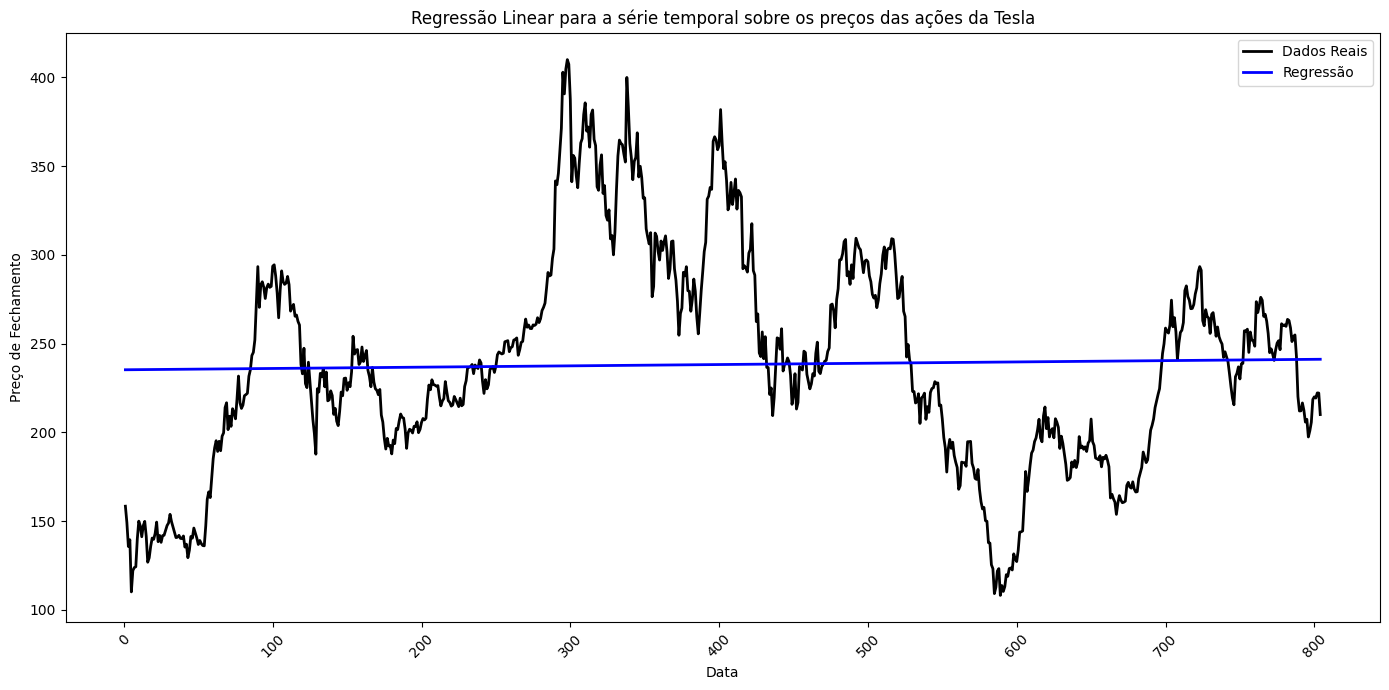

In [33]:
predicao_reg_lin_TSLA = model.predict(X_train)


plt.figure(figsize=(14, 7))
plt.plot(X_train, data_train['TSLA']['Close'], color='black', label='Dados Reais', linewidth=2)
plt.plot(X_train, predicao_reg_lin_TSLA, color='blue', label='Regressão', linewidth=2)
plt.title('Regressão Linear para a série temporal sobre os preços das ações da Tesla')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.legend()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

### ABORDAGEM COM LAGS

In [35]:
data_train_with_lags['TSLA']

,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
10,2020-09-16,147.253326,149.919998,122.093330,135.666672,158.350006
11,2020-09-17,141.143326,147.253326,123.779999,139.440002,149.123337
12,2020-09-18,147.383331,141.143326,124.239998,110.070000,135.666672
13,2020-09-21,149.796661,147.383331,139.873337,122.093330,139.440002
14,2020-09-22,141.410004,149.796661,149.919998,123.779999,110.070000
...,...,...,...,...,...,...
801,2023-11-07,222.179993,219.270004,200.839996,205.759995,216.520004
802,2023-11-08,222.110001,222.179993,205.660004,207.300003,212.419998
803,2023-11-09,209.979996,222.110001,218.509995,197.360001,205.759995
804,2023-11-10,214.649994,209.979996,219.960007,200.839996,207.300003


In [43]:
X_with_lags = pd.concat([pd.DataFrame(X_train), data_train_with_lags['TSLA'].loc[:, ['(Close-1)', '(Close-5)', '(Close-8)', '(Close-10)']]], axis=1).dropna()
X_with_lags

y = data_train['TSLA']['Close'].iloc[10:]
X_with_lags.columns = X_with_lags.columns.astype(str)


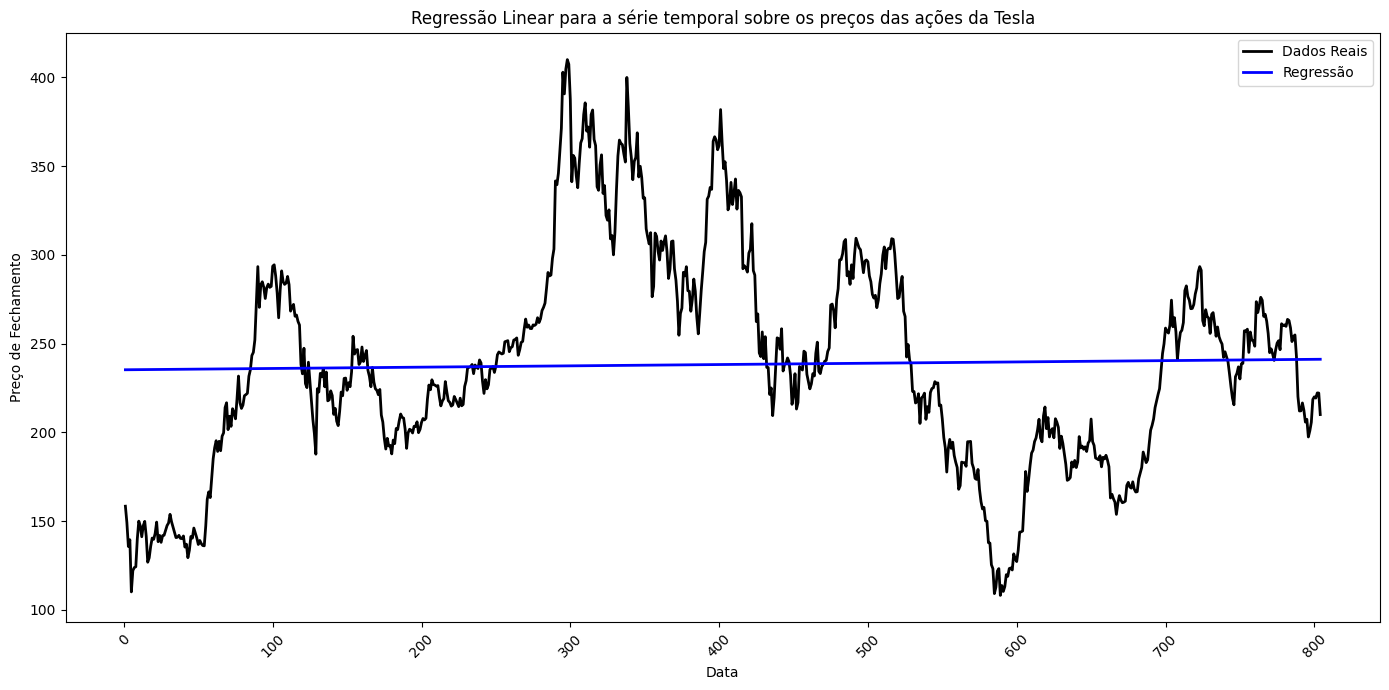

In [44]:
predicao_reg_lin_TSLA = model.predict(X_train)


plt.figure(figsize=(14, 7))
plt.plot(X_train, data_train['TSLA']['Close'], color='black', label='Dados Reais', linewidth=2)
plt.plot(X_train, predicao_reg_lin_TSLA, color='blue', label='Regressão', linewidth=2)
plt.title('Regressão Linear para a série temporal sobre os preços das ações da Tesla')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.legend()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [45]:
model_lin_reg_with_lags = LinearRegression()
model_lin_reg_with_lags.fit(X_with_lags, y)

LinearRegression()

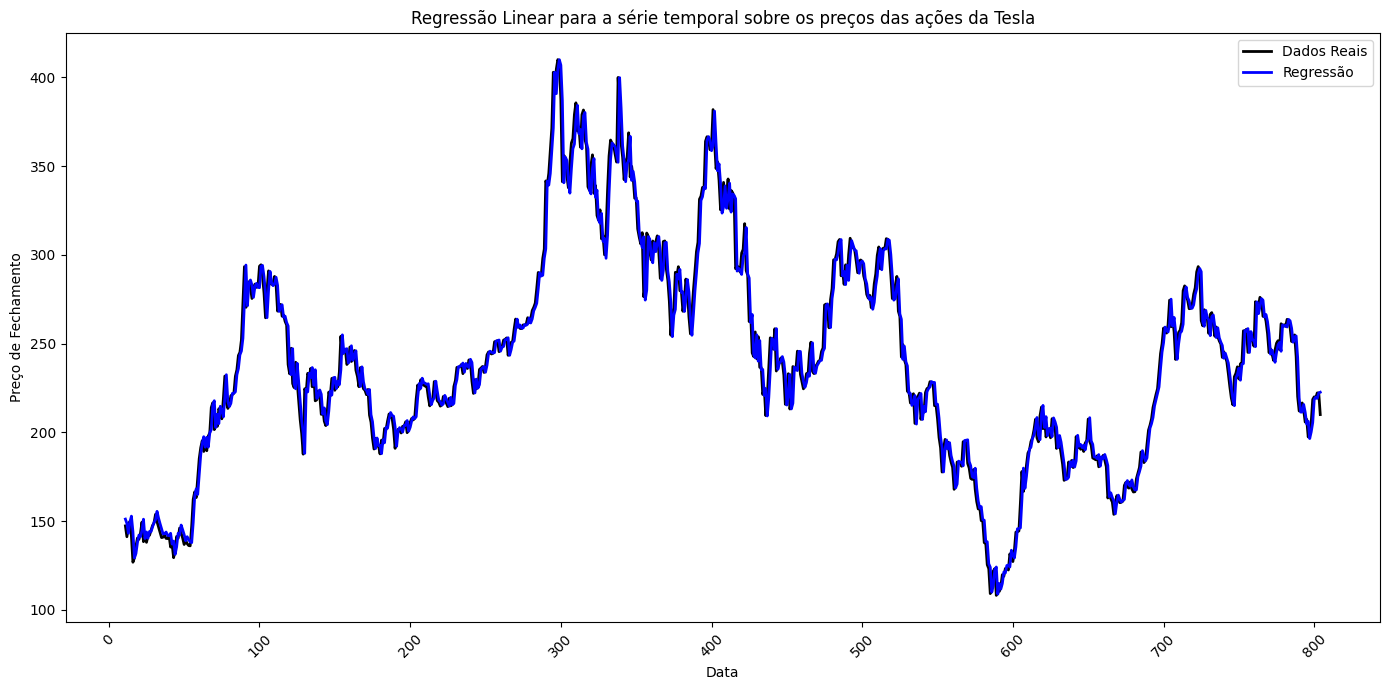

In [46]:
predicao_com_lags = model_lin_reg_with_lags.predict(X_with_lags)

plt.figure(figsize=(14, 7))
plt.plot(X_with_lags['0'], y, color='black', label='Dados Reais', linewidth=2)
plt.plot(X_with_lags['0'], predicao_com_lags, color='blue', label='Regressão', linewidth=2)
plt.title('Regressão Linear para a série temporal sobre os preços das ações da Tesla')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.legend()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [47]:
e1 = y - predicao_com_lags

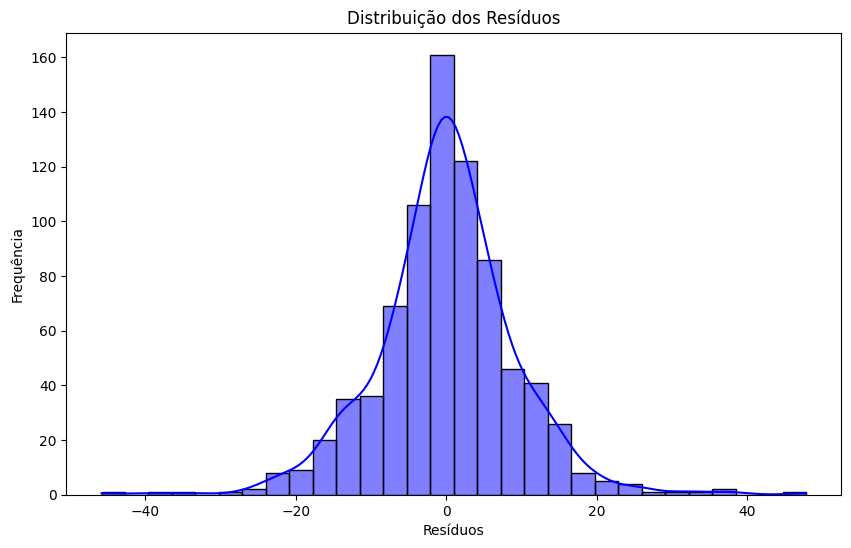

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(e1, kde=True, color='blue', bins=30)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

In [49]:
# Teste de Shapiro-Wilk
stat, p_value = stats.shapiro(e1)
print(f'Estatística do Teste de Shapiro-Wilk: {stat:.4f}, p-value: {p_value:.4f}')

if p_value > 0.05:
    print("Os resíduos seguem uma distribuição normal (não rejeitamos H0).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos H0).")

Estatística do Teste de Shapiro-Wilk: 0.9688, p-value: 0.0000
Os resíduos não seguem uma distribuição normal (rejeitamos H0).


In [50]:
res = LinearRegression()
res.fit(X_with_lags,e1)

LinearRegression()

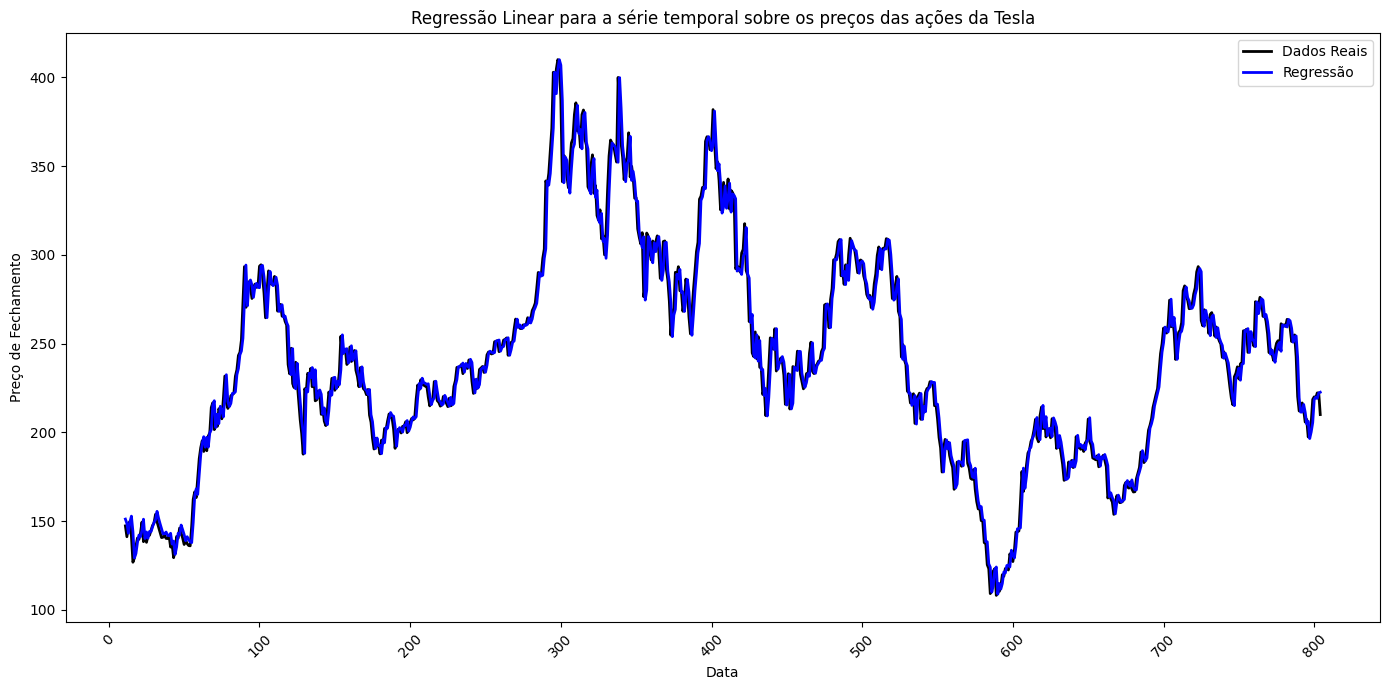

In [51]:
predicao_com_lags_e1 = res.predict(X_with_lags)

plt.figure(figsize=(14, 7))
plt.plot(X_with_lags['0'], y, color='black', label='Dados Reais', linewidth=2)
plt.plot(X_with_lags['0'], predicao_com_lags + predicao_com_lags_e1, color='blue', label='Regressão', linewidth=2)
plt.title('Regressão Linear para a série temporal sobre os preços das ações da Tesla')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.legend()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [52]:
e2 = y - predicao_com_lags + predicao_com_lags_e1

In [53]:
def normalidade_erros(erro):
    stat, p_value = stats.shapiro(erro)
    print(f'Estatística do Teste de Shapiro-Wilk: {stat:.4f}, p-value: {p_value:.4f}')

    if p_value > 0.05:
        print("Não rejeitamos H0, os erros são normais")
        return True  # Não rejeitamos H0, os erros são normais
    else:
        print("Rejeitamos H0, os erros não são normais")
        return False  # Rejeitamos H0, os erros não são normais

def reg_lin_mod_error(X_train, y):
    modelos = []
    erros = []
    predicao = []

    # Primeira regressão linear
    modelo = LinearRegression()
    modelo.fit(X_train, y)
    pred = modelo.predict(X_train)
    erro = y - pred

    modelos.append(modelo)
    predicao.append(pred)
    erros.append(erro)

    auxiliar = 0
    max_iter = 10  # Limite de iterações para evitar loops infinitos
    while normalidade_erros(erros[auxiliar]) is True and auxiliar < max_iter:
        auxiliar += 1
        print(f'Iteração {auxiliar}: Ajustando um novo modelo com os erros.')

        # Regressão nos erros anteriores
        novo_modelo = LinearRegression()
        novo_modelo.fit(X_train, erros[auxiliar-1])
        nova_pred = novo_modelo.predict(X_train)
        novo_erro = erros[auxiliar-1] - nova_pred

        # Atualiza as listas com os novos valores
        modelos.append(novo_modelo)
        predicao.append(nova_pred)
        erros.append(novo_erro)

        if auxiliar == max_iter:
            print("Número máximo de iterações atingido. Normalidade não foi alcançada.")
            break

    return modelos, erros, predicao

In [95]:
modelos,erros , predicao = reg_lin_mod_error(X_with_lags,y)

Estatística do Teste de Shapiro-Wilk: 0.9688, p-value: 0.0000
Rejeitamos H0, os erros não são normais


### AJUSTE DA RETA COM LAGS

In [96]:
predicao_com_lags_completo = np.zeros((len(predicao[0]),1))
predicao_com_lags_completo = predicao_com_lags_completo.reshape(-1,1)
erros = np.array(erros[0])
for i in range(len(erros)):
    predicao_com_lags_completo += predicao[0][i] + erros[i]
predicao_com_lags_completo = predicao_com_lags_completo/len(erros)


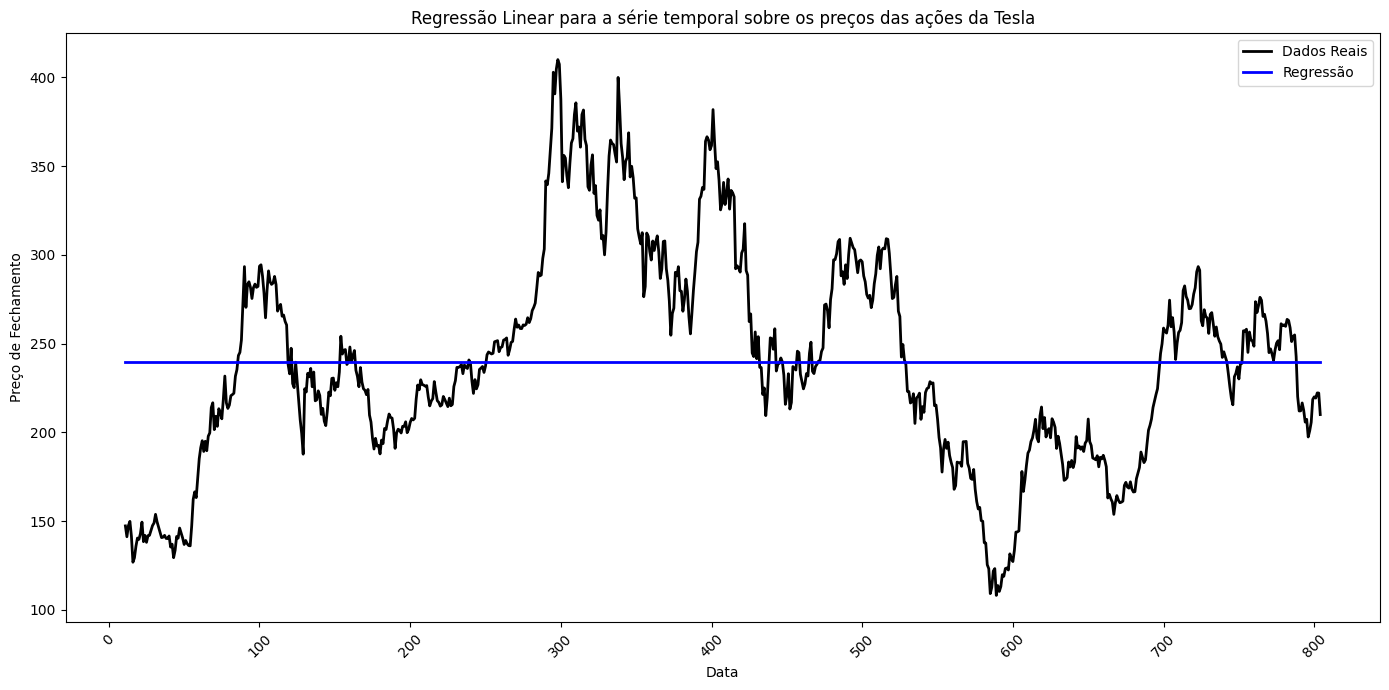

In [97]:
plt.figure(figsize=(14, 7))
plt.plot(X_with_lags['0'], y, color='black', label='Dados Reais', linewidth=2)
plt.plot(X_with_lags['0'], predicao_com_lags_completo, color='blue', label='Regressão', linewidth=2)
plt.title('Regressão Linear para a série temporal sobre os preços das ações da Tesla')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.legend()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [99]:
predicao_array = np.array(predicao)
ajuste_completo = np.sum(predicao_array, axis=0)

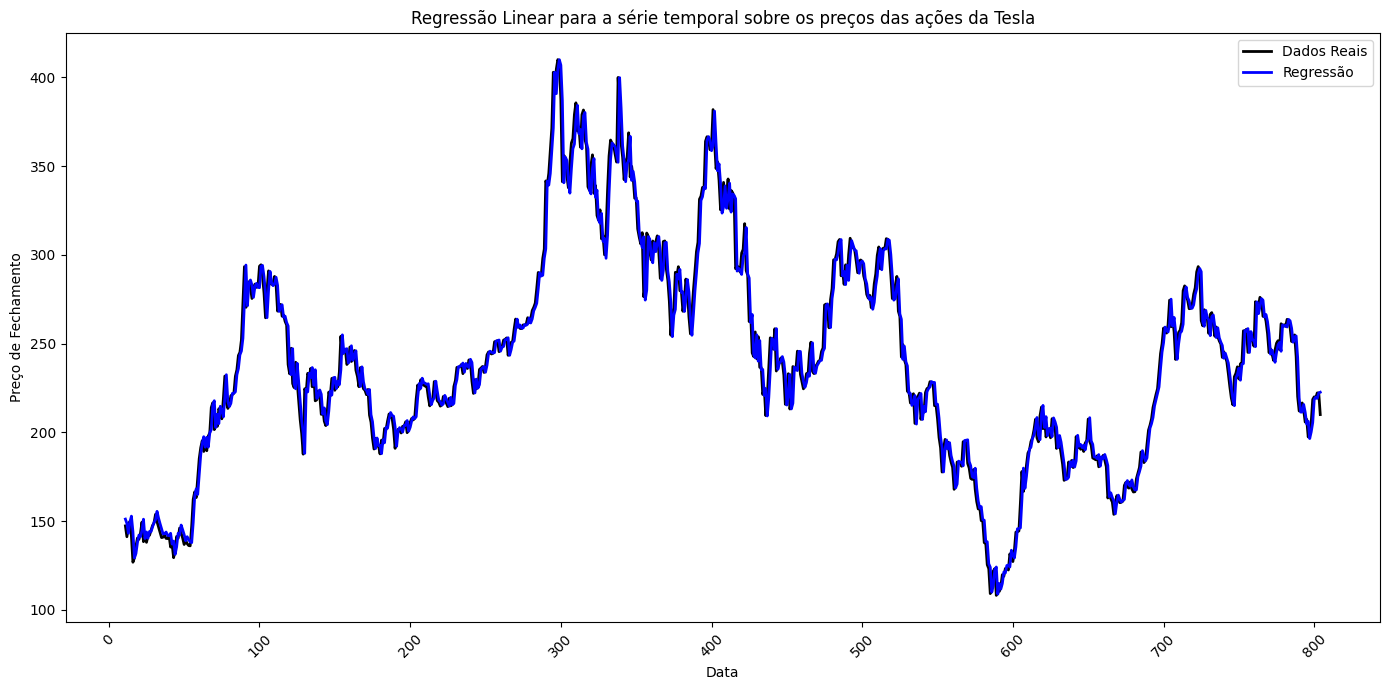

In [100]:
plt.figure(figsize=(14, 7))
plt.plot(X_with_lags['0'], y, color='black', label='Dados Reais', linewidth=2)
plt.plot(X_with_lags['0'], ajuste_completo, color='blue', label='Regressão', linewidth=2)
plt.title('Regressão Linear para a série temporal sobre os preços das ações da Tesla')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.legend()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [101]:
calcular_metricas_regressao(y, ajuste_completo)

,Métrica,Valor
0,MAE,6.631511
1,MSE,84.743742
2,MAPE,2.790497
3,RMSE,9.205636
4,R²,0.976372
5,THEIL,0.986873
6,ARV,0.023628
7,WPOCID,0.491803


### ONE-STEP-AHEAD

In [103]:
X_valor_para_prever = X_with_lags[['0', '(Close-1)', '(Close-5)', '(Close-8)', '(Close-10)']].iloc[-1].values.reshape(1, -1)

# Somar 1 ao primeiro elemento (índice 0)
X_valor_para_prever[0, 0] += 1  # Acessando o primeiro elemento do array

In [104]:
one_step_ahead = 0
for i in range(1, len(modelos) + 1):
    one_step_ahead += modelos[i - 1].predict(X_valor_para_prever)

In [105]:
data_test['TSLA']['Close'].iloc[0]

214.6499938964844

In [106]:
float(one_step_ahead)

222.5672502942567

In [107]:
print(f'Valor previsto para um dia a fente: {one_step_ahead}')
print(f'Valor observado: {data_test['TSLA']['Close'].iloc[0]}')

Valor previsto para um dia a fente: [222.56725029]
Valor observado: 214.6499938964844


In [108]:
calcular_metricas_regressao(data_test['TSLA']['Close'].iloc[0], one_step_ahead[0])

,Métrica,Valor
0,MAE,7.917256
1,MSE,62.682949
2,MAPE,3.688449
3,RMSE,7.917256
4,R²,N/A
5,THEIL,NaN
6,ARV,NaN
7,WPOCID,NaN


In [112]:
def previsao_multistep(modelos, X_with_lags, steps_a_frente=5):
    # Inicializar o conjunto de lags (última linha dos dados de lags)
    X_valor_para_prever = X_with_lags[['0', '(Close-1)', '(Close-5)', '(Close-8)', '(Close-10)']].iloc[-1].values.reshape(1, -1)
    
    previsoes = []
    for step in range(steps_a_frente):
        # Somar previsões de todos os modelos (ensemble)
        one_step_ahead = 0
        for i in range(1, len(modelos) + 1):
            one_step_ahead += modelos[i - 1].predict(X_valor_para_prever) 
        # Armazena a previsão combinada
        previsoes.append(one_step_ahead[0])
        # Atualizar o lag mais recente com o valor previsto
        X_valor_para_prever[0, 1] = one_step_ahead
        # Atualizar os outros lags (deslocando-os para a direita)
        X_valor_para_prever[0, 2:] = X_valor_para_prever[0, 1:-1]
    
    return previsoes

In [113]:
data_test['TSLA'].shape[0]

202

In [114]:
previsao_multi_step_ahead = previsao_multistep(modelos, X_with_lags, steps_a_frente=data_test['TSLA'].shape[0])

In [115]:
calcular_metricas_regressao(data_test['TSLA']['Close'], previsao_multi_step_ahead )

,Métrica,Valor
0,MAE,30.319098
1,MSE,1194.126934
2,MAPE,16.156295
3,RMSE,34.556142
4,R²,-0.315714
5,THEIL,24.127812
6,ARV,1.315714
7,WPOCID,0.502488


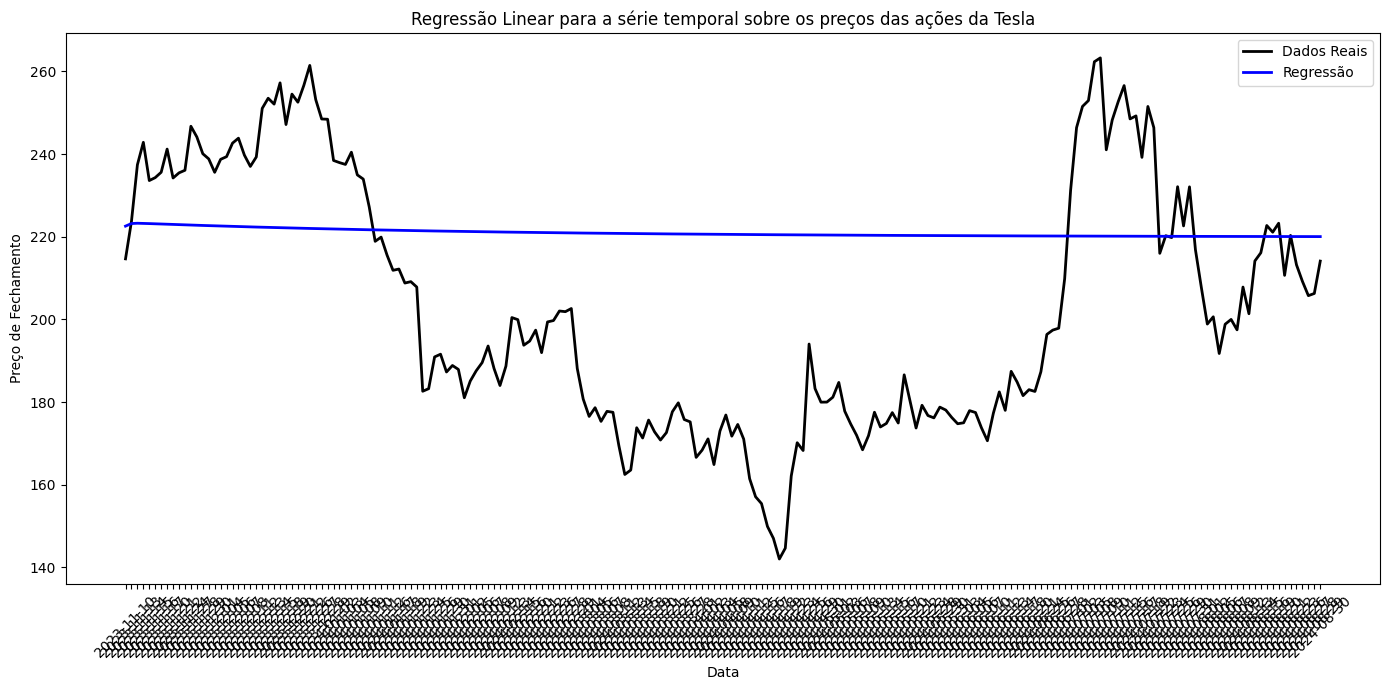

In [116]:
plt.figure(figsize=(14, 7))
plt.plot(data_test['TSLA']['Date'], data_test['TSLA']['Close'], color='black', label='Dados Reais', linewidth=2)
plt.plot(data_test['TSLA']['Date'], previsao_multi_step_ahead, color='blue', label='Regressão', linewidth=2)
plt.title('Regressão Linear para a série temporal sobre os preços das ações da Tesla')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.legend()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

- Observação sobre o resíduo e a definição de lags sobre a função de autocorrelação

# REFERÊNCIAS



França, A. (2023, 18 de janeiro). Teste de Levene. Blog Psicometria Online. https://www.blog.psicometriaonline.com.br/teste-de-levene/

ALMEIDA, Antonia Erilânia de. Modificações e alternativas aos testes de Levene e Brown e Forsythe para igualdade de variâncias e médias. 2006. Dissertação (Mestrado em Ciências) – Instituto de Matemática e Estatística, Universidade de São Paulo, São Paulo, 2006.

MARTINS, Guilherme Santos; GIESBRECHT, Mateus. Decomposição de Séries Temporais Utilizando os Algoritmos SSA e SSA Recursivo. Disponível em: https://www.sba.org.br/cba2022/wp-content/uploads/artigos_cba2022/paper_1296.pdf. Acessado em [21/09/2024].

FREITAS, Suelem Torres de. Análise Bayesiana dos Modelos de Regressão Linear com Erros Simétricos Autorregressivos e Dados Incompletos. 2022. Dissertação (Mestrado em Estatística) — Universidade Federal de Pernambuco, Centro de Ciências Exatas e da Natureza, Recife, 2022

HEARD, Nick. An introduction to Bayesian inference, methods and computation. 2021. Springer.